In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install sdv

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

In [5]:
# read csv file as dataframe, and drop ROW_ID column
def read_csv_no_rowid(file_path):
    df = pd.read_csv(file_path)
    df.drop(["Unnamed: 0", 'row_id'], axis=1, inplace=True)

    return df

In [6]:
# check NaN value

def nan_count(df):
    print("Total columns: " + str(len(df.columns)))
    print("Total rows: " + str(len(df)))
    print("--------------")
    print(df.isnull().sum())

In [7]:
date_set_path = "../temp_sets/"

In [8]:
outputevents_sample_df = read_csv_no_rowid(date_set_path + "outputevents.csv")

In [9]:
outputevents_sample_df.head()

,subject_id,hadm_id,icustay_id,charttime,itemid,value,valueuom,storetime,cgid,stopped,newbottle,iserror
0,11290,137961.0,264377.0,2173-11-26 00:30:00,43175,26.0,ml,2173-11-26 00:35:00,17206,NaN,NaN,NaN
1,11290,137961.0,264377.0,2173-11-20 02:00:00,43175,3.0,ml,2173-11-20 03:13:00,17581,NaN,NaN,NaN
2,11290,137961.0,264377.0,2173-11-20 08:00:00,43175,28.0,ml,2173-11-20 11:38:00,14489,NaN,NaN,NaN
3,11290,137961.0,264377.0,2173-11-20 12:30:00,43175,12.0,ml,2173-11-20 14:38:00,14489,NaN,NaN,NaN
4,11290,137961.0,264377.0,2173-11-20 20:30:00,43175,11.0,ml,2173-11-20 21:46:00,18125,NaN,NaN,NaN


In [10]:
outputevents_sample_df.dropna(subset=['hadm_id'], inplace=True, axis=0)
outputevents_sample_df.dropna(subset=['icustay_id'], inplace=True, axis=0)

In [11]:
outputevents_sample_df.drop(['valueuom', 'storetime', 'cgid', 'stopped', 'newbottle', 'iserror'], axis=1, inplace=True)

In [12]:
nan_count(outputevents_sample_df)

Total columns: 6
Total rows: 100914
--------------
subject_id       0
hadm_id          0
icustay_id       0
charttime        0
itemid           0
value         1840
dtype: int64


In [13]:
outputevents_sample_df['value'].fillna(value=0, inplace=True)

In [14]:
nan_count(outputevents_sample_df)

Total columns: 6
Total rows: 100914
--------------
subject_id    0
hadm_id       0
icustay_id    0
charttime     0
itemid        0
value         0
dtype: int64


In [15]:
outputevents_sample_df['subject_id'] = outputevents_sample_df['subject_id'].astype(str)
outputevents_sample_df['hadm_id'] = outputevents_sample_df['hadm_id'].astype(str)
outputevents_sample_df['icustay_id'] = outputevents_sample_df['icustay_id'].astype(str)

outputevents_sample_df['itemid'] = outputevents_sample_df['itemid'].astype(str)

outputevents_sample_df['charttime'] = pd.to_datetime(outputevents_sample_df['charttime'])

In [16]:
outputevents_sample_df.dtypes

subject_id            object
hadm_id               object
icustay_id            object
charttime     datetime64[ns]
itemid                object
value                float64
dtype: object

In [17]:
len(outputevents_sample_df)

100914

---

## Build model

In [18]:
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate
from sdv.constraints import FixedCombinations

In [19]:
outputevents_sample_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'charttime', 'itemid', 'value'], dtype='object')

In [20]:
fixed_subject_hadm_icustay_constraint = FixedCombinations(
    column_names=['subject_id', 'hadm_id', 'icustay_id'],
    handling_strategy='transform'
)

fixed_item_value_linkorderid_constraint = FixedCombinations(
    column_names=['itemid', 'value']
)

In [21]:
outputevents_constraints = [fixed_subject_hadm_icustay_constraint, fixed_item_value_linkorderid_constraint]

In [44]:
model = CTGAN(
    constraints=outputevents_constraints, 
    batch_size=1000,
    cuda=True, 
    verbose=True, 
    epochs=50)

In [45]:
len(outputevents_sample_df)

100914

In [46]:
train_data = outputevents_sample_df.sample(n=10000)
model.fit(train_data)

Epoch 1, Loss G:  7.0900,Loss D: -0.0110
Epoch 2, Loss G:  7.0435,Loss D: -0.0171
Epoch 3, Loss G:  6.9911,Loss D: -0.0238
Epoch 4, Loss G:  6.9627,Loss D: -0.0411
Epoch 5, Loss G:  6.9542,Loss D: -0.0441
Epoch 6, Loss G:  6.8654,Loss D: -0.0649
Epoch 7, Loss G:  6.8574,Loss D: -0.0529
Epoch 8, Loss G:  6.8752,Loss D: -0.0854
Epoch 9, Loss G:  6.8053,Loss D: -0.0667
Epoch 10, Loss G:  6.8171,Loss D: -0.0847
Epoch 11, Loss G:  6.7681,Loss D: -0.1037
Epoch 12, Loss G:  6.7314,Loss D: -0.0506
Epoch 13, Loss G:  6.6370,Loss D: -0.0532
Epoch 14, Loss G:  6.6583,Loss D: -0.0940
Epoch 15, Loss G:  6.5774,Loss D: -0.0119
Epoch 16, Loss G:  6.4979,Loss D: -0.0255
Epoch 17, Loss G:  6.4109,Loss D: -0.0486
Epoch 18, Loss G:  6.2120,Loss D:  0.0251
Epoch 19, Loss G:  6.1741,Loss D: -0.0635
Epoch 20, Loss G:  5.9786,Loss D: -0.0547
Epoch 21, Loss G:  5.7018,Loss D:  0.0108
Epoch 22, Loss G:  5.6266,Loss D: -0.0712
Epoch 23, Loss G:  5.4505,Loss D: -0.0467
Epoch 24, Loss G:  5.1874,Loss D:  0.0120
E

In [32]:
model.save("../outputevents_model.pkl")

In [26]:
# model = CTGAN.load(("/content/drive/MyDrive/MSc Project/outputevents_model.pkl"))

In [47]:
sample = model.sample(num_rows=10000)

In [34]:
nan_count(sample)

Total columns: 6
Total rows: 10000
--------------
subject_id    0
hadm_id       0
icustay_id    0
charttime     0
itemid        0
value         0
dtype: int64


In [35]:
sample.dtypes

subject_id            object
hadm_id               object
icustay_id            object
charttime     datetime64[ns]
itemid                object
value                float64
dtype: object

In [37]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

nan

In [48]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.4859559525161048

<AxesSubplot:xlabel='itemid', ylabel='value'>

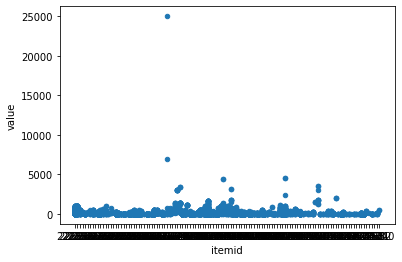

In [70]:
sample.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')

<AxesSubplot:xlabel='itemid', ylabel='value'>

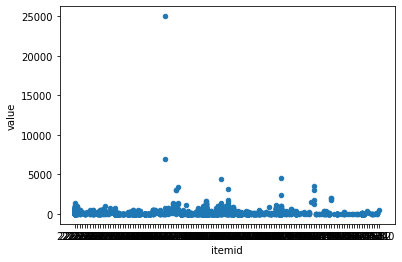

In [71]:
train_data.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')

In [40]:
evaluate(sample, train_data, aggregate=False)

KeyboardInterrupt: 